# Stock Price Forecasting with CNNs and LSTMs (Time Series Analysis)

### Import the Libraries

In [743]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

### Plot Utility

In [746]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    
    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      for y_curr in y:

          plt.plot(x[start:end], y_curr[start:end], format)

    else:
      
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

### Extract the AAPL Stock Data using yfinance Library

In [781]:
data = yf.download('AAPL', start='2010-01-01', end='2025-04-10')

[*********************100%***********************]  1 of 1 completed


In [783]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.440330,6.455076,6.391278,6.422876,493729600
2010-01-05,6.451466,6.487879,6.417460,6.458087,601904800
2010-01-06,6.348847,6.477046,6.342226,6.451466,552160000
2010-01-07,6.337110,6.379844,6.291067,6.372320,477131200
2010-01-08,6.379240,6.379842,6.291367,6.328682,447610800


In [785]:
data.tail()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-04-03,203.190002,207.490005,201.250000,205.539993,103419000
2025-04-04,188.380005,199.880005,187.339996,193.889999,125910900
2025-04-07,181.460007,194.149994,174.619995,177.199997,160466300
2025-04-08,172.419998,190.339996,169.210007,186.699997,120859500
2025-04-09,198.850006,200.610001,171.889999,171.949997,184067400


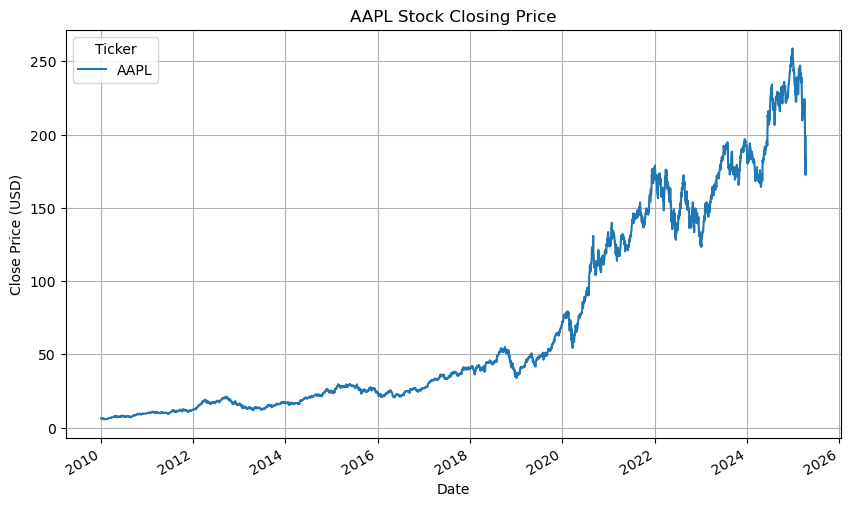

In [787]:
data['Close'].plot(figsize=(10, 6))
plt.title('AAPL Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.grid(True)
plt.show()

### Prepare the dataset

In [758]:
# Normalize the dataset
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data['Close'])
scaled_data = scaled_data.reshape(-1)
scaled_data

array([0.00261252, 0.00265654, 0.00225086, ..., 0.69451016, 0.65877268,
       0.76325728])

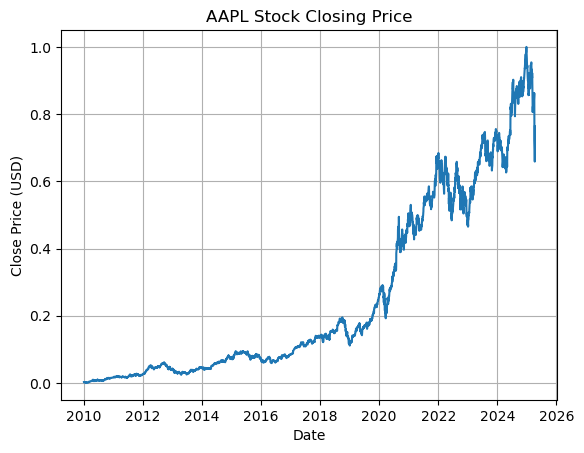

In [760]:
# Plot the Normalized dataset
plt.plot(data.reset_index()['Date'], scaled_data )
plt.title('AAPL Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.grid(True)
plt.show()

In [762]:
# Generate dataset windows
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    
    dataset = dataset.shuffle(shuffle_buffer)
    
    dataset = dataset.batch(batch_size)
    
    dataset = dataset.cache().prefetch(1)
    
    return dataset

In [764]:
# Define the split time
split_time = int(0.9 * len(scaled_data))

# Get the train set 
x_train = scaled_data[:split_time]
time_train = data.reset_index()['Date'][:split_time]

# Get the validation set
x_valid = scaled_data[split_time:]
time_valid = data.reset_index()['Date'][split_time:]

In [766]:
# Parameters
window_size = 7
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

### Build and Compile the Model

In [769]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,1)),
    tf.keras.layers.Conv1D(filters=16, kernel_size=5, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(50, return_sequences=True),
    tf.keras.layers.LSTM(50), 
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

# Print the model summary
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)                   │ (None, 7, 16)               │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 3, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_20 (LSTM)                       │ (None, 3, 50)               │          13,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 100)                 │           5,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,897 (151.94 KB)

 Trainable params: 38,897 (151.94 KB)

 Non-trainable params: 0 (0.00 B)

In [771]:
model.compile(loss="mae",
              optimizer="adam",
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0196 - mae: 0.0196
Epoch 2/100
 17/108 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0055 - mae: 0.0055

C:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0088 - mae: 0.0088
Epoch 3/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0074 - mae: 0.0074
Epoch 4/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0072 - mae: 0.0072
Epoch 5/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0071 - mae: 0.0071
Epoch 6/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0071 - mae: 0.0071
Epoch 7/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0073 - mae: 0.0073
Epoch 8/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0069 - mae: 0.0069
Epoch 9/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0072 - mae: 0.0072
Epoch 10/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0073 - mae: 0.0073
Epoch 11/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0073 - mae: 0.0073
Epoch 12/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0073 - mae: 0.0073
Epoch 13/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0079 - mae: 0.0079
Epoch 14/100
108/108 ━━━

### Model Forecasting

In [773]:
def model_forecast(model, series, window_size, batch_size):
    
    dataset = tf.data.Dataset.from_tensor_slices(series)

    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    dataset = dataset.batch(batch_size).prefetch(1)

    forecast = model.predict(dataset, verbose=0)
    
    return forecast

C:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


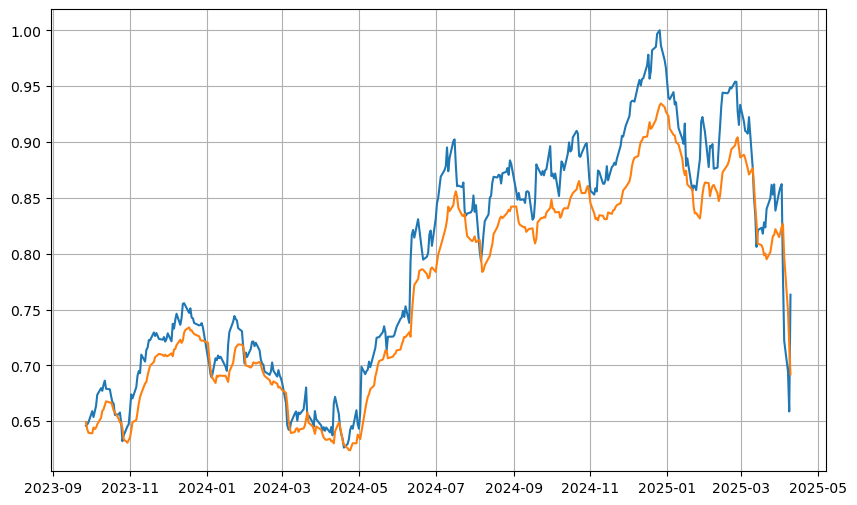

In [774]:
# Reduce the original series
forecast_series = scaled_data[split_time-window_size:-1]

forecast = model_forecast(model, forecast_series, window_size, batch_size)

results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [775]:
# Compute the MAE
print(tf.keras.metrics.mae(x_valid, results).numpy())

0.028208006
